# 텍스트 감성 분류

해당 소스코드는 https://wikidocs.net/94600 링크를 참조하였습니다.

## 1. 환경설정

In [2]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 28.91 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-12-28 14:17:20--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::3403:4be7, 2406:da00:ff00::22cd:e0db, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 2. 데이터 로드하기 

데이터셋 : 네이버 영화리뷰 + 네이버 쇼핑리뷰 (40만개)

수업에서 네이버 쇼핑리뷰 데이터셋 20만개가 기본적으로 제공되었습니다. 

외부 데이터 사용이 허용되어서 네이버 영화리뷰 데이터셋과 병합하여 학습데이터로 사용하였습니다. 

In [4]:
# 데이터셋을 csv로 읽어들인다.
total_data = pd.read_csv('/content/data/dataset.csv')
# 상위 5개의 샘플만 출력해본다. 
total_data.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,document,label
0,굳 ㅋ,1
1,GDNTOPCLASSINTHECLUB,0
2,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## 새로운 테스트 데이터

기말프로젝트에서 테스트데이터셋의 갯수가 1000개이기에 실제 테스트환경과 동일하게 만들어주도록 하였습니다. 이에 임의로 label을 갖지 않는 data 1000개로 이루어진 csv 파일을 만들었습니다. 

total_data에서 사용되지 않았던 배민 리뷰 데이터셋으로 구성되어 있습니다.

In [6]:
ttest = pd.read_csv('/content/data/nolabel_test.csv', encoding='cp949')
ttest.head()

,document
0,친절하시고 깔끔하고 좋았습니다
1,조용하고 고기도 굿
2,"갈비탕과 냉면, 육회비빔밥이 맛있습니다."
3,대체적으로 만족하나\n와인의 구성이 살짝 아쉬움
4,고기도 맛있고 서비스는 더 최고입니다~


In [8]:
len(ttest)

1000

## 3. 데이터 전처리

In [9]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42) # 여기서 test_data는 validation dataset을 의미한다.
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 300001
테스트용 리뷰의 개수 : 100001


In [10]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['document'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how='any') # Null 값 제거
print('전처리 후 학습용 샘플의 개수 :',len(train_data))
print(train_data.isnull().sum())

<ipython-input-10-bc5c17f09fb5>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


전처리 후 학습용 샘플의 개수 : 299153
document    0
label       0
dtype: int64


ttest

In [11]:
# 한글과 공백을 제외하고 모두 제거
ttest['document'] = ttest['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
ttest['document'].replace('', np.nan, inplace=True)
ttest = ttest.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(ttest))
print(ttest.isnull().sum())

전처리 후 테스트용 샘플의 개수 : 997
document    0
dtype: int64


<ipython-input-11-dd597f8b01c6>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  ttest['document'] = ttest['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [12]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))
print(test_data.isnull().sum())

전처리 후 테스트용 샘플의 개수 : 98947
document    0
label       0
dtype: int64


<ipython-input-12-49951f1540a6>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


In [13]:
len(train_data)+len(test_data)

398100

## 4. 토큰화

In [14]:
mecab = Mecab()

In [15]:
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [16]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [17]:
train_data['tokenized'] = train_data['document'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [18]:
test_data['tokenized'] = test_data['document'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

ttest

In [19]:
ttest['tokenized'] = ttest['document'].apply(mecab.morphs)
ttest['tokenized'] = ttest['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [20]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [21]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 21929), ('는데', 14066), ('안', 13440), ('어요', 10066), ('너무', 9124), ('있', 9020), ('했', 8037), ('배송', 6721), ('좋', 6695), ('같', 6236), ('거', 6159), ('구매', 6095), ('어', 6061), ('아요', 6021), ('없', 5895), ('습니다', 5804), ('그냥', 5784), ('되', 5703), ('잘', 5577), ('않', 5470)]


In [22]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 27609), ('아요', 14600), ('네요', 13726), ('어요', 12966), ('잘', 12864), ('구매', 11244), ('습니다', 9366), ('있', 8697), ('배송', 8436), ('는데', 8139), ('합니다', 6818), ('했', 6798), ('먹', 6640), ('재', 6468), ('너무', 5788), ('같', 5432), ('만족', 5060), ('거', 4534), ('어', 4333), ('쓰', 4321)]


긍정 리뷰의 평균 길이 : 13.570649870950344
부정 리뷰의 평균 길이 : 17.029018420388596


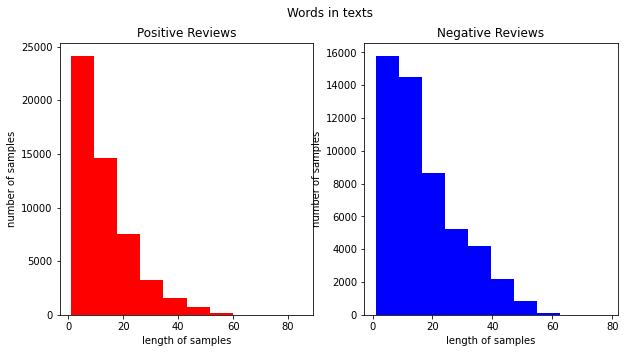

In [23]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [24]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

ttest

In [25]:
a_test= ttest['tokenized'].values
# b_test = ttest['index'].values

## 5. 정수 인코딩

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [27]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 70978
등장 빈도가 1번 이하인 희귀 단어의 수: 30765
단어 집합에서 희귀 단어의 비율: 43.34441657978528
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.750298143826045


In [28]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 40215


In [29]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

ttest

In [30]:
a_test = tokenizer.texts_to_sequences(a_test)

In [31]:
print(a_test[:3])

[[635, 77, 224, 2, 31, 15], [2683, 756, 186], [24614, 6093, 15749, 11346, 121, 15]]


In [ ]:
# print(X_train[:3])

In [32]:
print(X_test[:3])

[[15445, 134, 245, 148, 74, 49, 32, 223, 23, 1975, 38], [3881, 214, 10, 355, 1127, 156, 5341, 298, 60, 348, 9, 776, 7367, 403, 27, 239, 852, 47, 30, 2, 3, 210, 415, 210, 10, 48, 39, 15], [303, 4654, 55, 3108, 547, 294, 850, 32, 561, 1631]]


리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 13.706598295855299


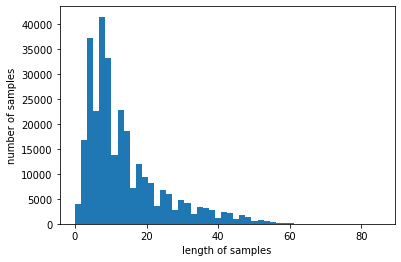

In [33]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [34]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [35]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933144578192


In [36]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

ttest

In [37]:
a_test = pad_sequences(a_test, maxlen=max_len)
a_test = a_test.astype(np.float32)

In [38]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

In [39]:
import torch

In [41]:
# gru
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('/content/model/best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
3736/3740 [============================>.] - ETA: 0s - loss: 0.3250 - acc: 0.8629
Epoch 1: val_acc improved from -inf to 0.88319, saving model to /content/model/best_model.h5
3740/3740 [==============================] - 39s 10ms/step - loss: 0.3250 - acc: 0.8630 - val_loss: 0.2852 - val_acc: 0.8832
Epoch 2/15
3740/3740 [==============================] - ETA: 0s - loss: 0.2689 - acc: 0.8922
Epoch 2: val_acc improved from 0.88319 to 0.89185, saving model to /content/model/best_model.h5
3740/3740 [==============================] - 36s 10ms/step - loss: 0.2689 - acc: 0.8922 - val_loss: 0.2686 - val_acc: 0.8918
Epoch 3/15
3737/3740 [============================>.] - ETA: 0s - loss: 0.2471 - acc: 0.9026
Epoch 3: val_acc improved from 0.89185 to 0.89307, saving model to /content/model/best_model.h5
3740/3740 [==============================] - 33s 9ms/step - loss: 0.2472 - acc: 0.9026 - val_loss: 0.2633 - val_acc: 0.8931
Epoch 4/15
3734/3740 [============================>.] - ETA: 0

In [40]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, embedding_dim))
model_lstm.add(LSTM(hidden_units))
model_lstm.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('/content/model/lstm_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_lstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model_lstm.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/15
7476/7479 [============================>.] - ETA: 0s - loss: 0.3290 - acc: 0.8614
Epoch 1: val_acc improved from -inf to 0.88234, saving model to /content/model/lstm_best_model.h5
7479/7479 [==============================] - 74s 9ms/step - loss: 0.3290 - acc: 0.8614 - val_loss: 0.2914 - val_acc: 0.8823
Epoch 2/15
7477/7479 [============================>.] - ETA: 0s - loss: 0.2763 - acc: 0.8894
Epoch 2: val_acc improved from 0.88234 to 0.88755, saving model to /content/model/lstm_best_model.h5
7479/7479 [==============================] - 72s 10ms/step - loss: 0.2763 - acc: 0.8894 - val_loss: 0.2775 - val_acc: 0.8875
Epoch 3/15
7479/7479 [==============================] - ETA: 0s - loss: 0.2586 - acc: 0.8984
Epoch 3: val_acc improved from 0.88755 to 0.89098, saving model to /content/model/lstm_best_model.h5
7479/7479 [==============================] - 67s 9ms/step - loss: 0.2586 - acc: 0.8984 - val_loss: 0.2698 - val_acc: 0.8910
Epoch 4/15
7475/7479 [==========================

In [42]:
#cnn 
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 32
dropout_ratio = 0.3
num_filters = 32
kernel_size = 5

model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, embedding_dim))
model_cnn.add(Dropout(dropout_ratio))
model_cnn.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(dropout_ratio))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('/content/model/cnn_best_model.h5', monitor = 'val_acc', mode='max', verbose=1, save_best_only=True)

history = model_cnn.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[es, mc])

Epoch 1/10
3740/3740 [==============================] - ETA: 0s - loss: 0.3710 - acc: 0.8412
Epoch 1: val_acc improved from -inf to 0.87376, saving model to /content/model/cnn_best_model.h5
3740/3740 [==============================] - 25s 5ms/step - loss: 0.3710 - acc: 0.8412 - val_loss: 0.3068 - val_acc: 0.8738
Epoch 2/10
3731/3740 [============================>.] - ETA: 0s - loss: 0.3001 - acc: 0.8802
Epoch 2: val_acc improved from 0.87376 to 0.87881, saving model to /content/model/cnn_best_model.h5
3740/3740 [==============================] - 20s 5ms/step - loss: 0.3000 - acc: 0.8802 - val_loss: 0.2965 - val_acc: 0.8788
Epoch 3/10
3735/3740 [============================>.] - ETA: 0s - loss: 0.2721 - acc: 0.8926
Epoch 3: val_acc improved from 0.87881 to 0.87888, saving model to /content/model/cnn_best_model.h5
3740/3740 [==============================] - 20s 5ms/step - loss: 0.2721 - acc: 0.8926 - val_loss: 0.2989 - val_acc: 0.8789
Epoch 4/10
3731/3740 [============================>.

In [ ]:
y_predict1 = model1.predict(a_test)

18/18 [==============================] - 0s 4ms/step


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/model/best_model.h5')
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

4260/4260 [==============================] - 15s 3ms/step - loss: 0.2422 - acc: 0.9052

 테스트 정확도: 0.9052


In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
loaded_model = load_model('/content/model/best_model.h5')
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

4260/4260 [==============================] - 15s 4ms/step - loss: 0.2422 - acc: 0.9052

 테스트 정확도: 0.9052


## 배민 리뷰데이터로 TEST 재진행

In [ ]:
loaded_model = load_model('/content/model/best_model.h5')
# a_test = a_test.astype(np.float32)
# b_test = b_test.astype(np.float32)
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(a_test, b_test)[1]))

18/18 [==============================] - 0s 5ms/step - loss: 0.1643 - acc: 0.9358

 테스트 정확도: 0.9358


In [ ]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from konlpy.tag import Okt
okt = Okt()

In [ ]:
submission = pd.read_csv('/content/csv/submission.csv')

In [ ]:
submission.head()

,Unnamed: 0,Answer
0,0,NaN
1,1,NaN
2,2,NaN
3,3,NaN
4,4,NaN


In [ ]:
submission['Answer'][1] = int(1)

<ipython-input-137-2b1edc8001f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Answer'][1] = int(1)


In [ ]:
submission.head()

,Unnamed: 0,Answer
0,0,1.0
1,1,1.0
2,2,1.0
3,3,1.0
4,4,1.0


In [ ]:
type(submission['Answer'][1])

numpy.float64

In [ ]:
def sentiment_predict(new_sentence, i):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(model.predict(pad_new))
  if(score > 0.5):
    submission['Answer'][i] = 1
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    submission['Answer'][i] = 0
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
def Hard_voting(new_sentence, i):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  count = 0

  y_predict1 = model1.predict(a_test)
  y_predict2 = model2.predict(a_test)
  y_predict3 = model3.predict(a_test)

  score1 = float(model.predict(pad_new))
  score2 = float(model.predict(pad_new))
  score3 = float(model.predict(pad_new))

  if(score1 > 0.5):
    count += 1
  
  if(score2 > 0.5):
    count += 1
  
  if(score3 > 0.5):
    count += 1

  if(count > 2):
    submission['Answer'][i] = 1
    print("긍정 리뷰")

  else:
    submission['Answer'][i] = 0
    print("부정 리뷰")

In [ ]:
for i in range(len(ttest)):
  sentiment_predict(ttest['document'][i], i)
  print(ttest['document'][i])

1/1 [==============================] - 0s 16ms/step
98.06% 확률로 긍정 리뷰입니다.
친절하시고 깔끔하고 좋았습니다
1/1 [==============================] - 0s 18ms/step
88.34% 확률로 긍정 리뷰입니다.
조용하고 고기도 굿
1/1 [==============================] - 0s 15ms/step
96.75% 확률로 긍정 리뷰입니다.
갈비탕과 냉면 육회비빔밥이 맛있습니다
1/1 [==============================] - 0s 17ms/step
82.00% 확률로 긍정 리뷰입니다.
대체적으로 만족하나와인의 구성이 살짝 아쉬움
1/1 [==============================] - 0s 18ms/step


<ipython-input-134-aef7c6e7b7cc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Answer'][i] = 1


98.69% 확률로 긍정 리뷰입니다.
고기도 맛있고 서비스는 더 최고입니다
1/1 [==============================] - 0s 15ms/step
95.30% 확률로 긍정 리뷰입니다.
고기가 입에서 녹아요 서비스도 최고였습니다
1/1 [==============================] - 0s 20ms/step
82.42% 확률로 부정 리뷰입니다.
입에서 살살녹는 최상급소고기를 맛보고왔습니다
1/1 [==============================] - 0s 17ms/step
97.88% 확률로 긍정 리뷰입니다.
고기도 구워주고 가성비 짱
1/1 [==============================] - 0s 20ms/step
94.79% 확률로 긍정 리뷰입니다.
콜키지 프리라서 와인을 가지고 가면 좋은 식당생고기가 플레이팅도 아주 예쁘게 나오고 고기 질도 좋아 만족했네여다만 가격이 후덜덜하여 자주는 못간다는 ㅎㅎ회식때 자주 가고 싶은 곳 찜콩입니다 ㅋㅋ
1/1 [==============================] - 0s 16ms/step
72.44% 확률로 긍정 리뷰입니다.
저렴하면서도 맛이 아주 좋았습니다구워주시는 서버분들의 정성이 고기 한점 한점에 깃들여져 최고의 저녁식사를 대접받은 기분입니다밑반찬 역시 소박하게 필요한것만 몇 가지로 구성되어 있고 무엇보다 고기의 풍미를 배가시키는 역할을 해 주었습니다심연한우 이러심연 곤란해여
1/1 [==============================] - 0s 19ms/step


<ipython-input-134-aef7c6e7b7cc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Answer'][i] = 0


98.23% 확률로 긍정 리뷰입니다.
맛있어요 양이 적지만 한우니까요 ㅋㅋ한우초밥도 맛있었습니다
1/1 [==============================] - 0s 17ms/step
96.77% 확률로 긍정 리뷰입니다.
분위기도 괜찮고 고기 퀄리티도 좋고 전반적으로 만족했어요 아쉬운건 반찬 종류가 적었어요
1/1 [==============================] - 0s 16ms/step
96.53% 확률로 긍정 리뷰입니다.
고기가 너무너무 맛있었습니다한우와 놀고온 기분이랄까 ㅎㅎ맛난 한우김치찌게 정말 최고입니다자주 찾아뵙겠습니다
1/1 [==============================] - 0s 17ms/step
98.80% 확률로 부정 리뷰입니다.
고기를 주문하면 소를 잡으러간건지 올 생각도 안하고식당은 작아서 번잡스럽기만하고서비스도 별로고 비싼맛큼 서비스도 별로 그래도 고기맛은 나쁘지 않으니 뭐 근데 재방문의사를 물어본다면 재방문의사 없음이요
1/1 [==============================] - 0s 27ms/step
97.80% 확률로 긍정 리뷰입니다.
오랜만에 생각나서 들려본 육덕등심 간만에 가니 이모님도 반겨주시고 와인한병 서비스 받았네요ㅋㅋㅋㅋ 올때마다 잘챙겨주셔서 정겨운느낌안고 옵니다 오늘식사도 역시 맛있었구요 역시 올때마다 만족하고 가는것같습니다 또올게요
1/1 [==============================] - 0s 16ms/step
71.98% 확률로 긍정 리뷰입니다.
맛있는 고기와 와인 마리아쥬 좋았습니다 뭉태기 못먹은게 아쉽네요
1/1 [==============================] - 0s 18ms/step
79.57% 확률로 긍정 리뷰입니다.
많이좋았습니다
1/1 [==============================] - 0s 21ms/step
97.46% 확률로 부정 리뷰입니다.
여긴 무조건 세트를 구입해야 하는게 있는데 그게 매우 악수인듯 돈을 벌고자 하는 전략이 매

In [ ]:
for i in range(len(ttest)):
  Hard_voting(ttest['document'][i], i)
  print(ttest['document'][i])

1/1 [==============================] - 0s 15ms/step
긍정 리뷰
친절하시고 깔끔하고 좋았습니다
18/18 [==============================] - 0s 2ms/step


<ipython-input-149-a047810276b0>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Answer'][i] = 1


1/1 [==============================] - 0s 18ms/step
긍정 리뷰
조용하고 고기도 굿
1/1 [==============================] - 0s 20ms/step
긍정 리뷰
갈비탕과 냉면 육회비빔밥이 맛있습니다
1/1 [==============================] - 0s 15ms/step
긍정 리뷰
대체적으로 만족하나와인의 구성이 살짝 아쉬움
1/1 [==============================] - 0s 17ms/step
긍정 리뷰
고기도 맛있고 서비스는 더 최고입니다
1/1 [==============================] - 0s 16ms/step
긍정 리뷰
고기가 입에서 녹아요 서비스도 최고였습니다
1/1 [==============================] - 0s 16ms/step
부정 리뷰
입에서 살살녹는 최상급소고기를 맛보고왔습니다
18/18 [==============================] - 0s 2ms/step


<ipython-input-149-a047810276b0>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Answer'][i] = 0


1/1 [==============================] - 0s 16ms/step
긍정 리뷰
고기도 구워주고 가성비 짱
1/1 [==============================] - 0s 17ms/step
긍정 리뷰
콜키지 프리라서 와인을 가지고 가면 좋은 식당생고기가 플레이팅도 아주 예쁘게 나오고 고기 질도 좋아 만족했네여다만 가격이 후덜덜하여 자주는 못간다는 ㅎㅎ회식때 자주 가고 싶은 곳 찜콩입니다 ㅋㅋ
1/1 [==============================] - 0s 17ms/step
긍정 리뷰
저렴하면서도 맛이 아주 좋았습니다구워주시는 서버분들의 정성이 고기 한점 한점에 깃들여져 최고의 저녁식사를 대접받은 기분입니다밑반찬 역시 소박하게 필요한것만 몇 가지로 구성되어 있고 무엇보다 고기의 풍미를 배가시키는 역할을 해 주었습니다심연한우 이러심연 곤란해여
1/1 [==============================] - 0s 15ms/step
긍정 리뷰
맛있어요 양이 적지만 한우니까요 ㅋㅋ한우초밥도 맛있었습니다
1/1 [==============================] - 0s 18ms/step
긍정 리뷰
분위기도 괜찮고 고기 퀄리티도 좋고 전반적으로 만족했어요 아쉬운건 반찬 종류가 적었어요
1/1 [==============================] - 0s 17ms/step
긍정 리뷰
고기가 너무너무 맛있었습니다한우와 놀고온 기분이랄까 ㅎㅎ맛난 한우김치찌게 정말 최고입니다자주 찾아뵙겠습니다
1/1 [==============================] - 0s 16ms/step
부정 리뷰
고기를 주문하면 소를 잡으러간건지 올 생각도 안하고식당은 작아서 번잡스럽기만하고서비스도 별로고 비싼맛큼 서비스도 별로 그래도 고기맛은 나쁘지 않으니 뭐 근데 재방문의사를 물어본다면 재방문의사 없음이요
1/1 [==============================] - 0s 14ms/step
긍정 리뷰
오랜만에 생각나서 들려

In [ ]:
c_test = submission['Answer'].values

In [ ]:
sentiment_predict(ttest['document'][0])

1/1 [==============================] - 1s 750ms/step
96.21% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

1/1 [==============================] - 0s 17ms/step
99.39% 확률로 부정 리뷰입니다.


In [ ]:
ttest['document'][0]

'친절하시고 깔끔하고 좋았습니다'

In [ ]:
submission['Answer'][0]

1.0

In [ ]:
submission['Answer'][544]

1.0

In [ ]:
for i in range(1000):
  print(submission['Answer'][i])

1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0


In [ ]:
import pandas as pd
df = pd.DataFrame(submission, columns = ['Answer'])

In [ ]:
df

,Answer
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
995,NaN
996,NaN
997,NaN
998,NaN


In [ ]:
df.to_csv("/content/csv/submission_.csv")

In [ ]:
submission_ = pd.read_csv("/content/csv/submission_.csv")

In [ ]:
b_test = submission_['Answer'][:545].values

In [ ]:
c_test = submission['Answer']

In [ ]:
c_test = c_test[:545]

In [ ]:
bamin = pd.read_csv('/content/csv/test.csv')

In [ ]:
for i in range(545):
  bamin['index'] = float(bamin['index'][i])

In [ ]:
bamin['index']

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
540    1.0
541    1.0
542    1.0
543    1.0
544    1.0
Name: index, Length: 545, dtype: float64

In [ ]:
c_test

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
540    0.0
541    0.0
542    1.0
543    1.0
544    1.0
Name: Answer, Length: 545, dtype: float64

In [ ]:
count = 0

for i in range(545):
  if (bamin['index'][i] == c_test[i]):
    count += 1
  
print(count)

469


In [ ]:
print((469/545)*100)

86.05504587155963


In [ ]:
loaded_model = load_model('/content/model/best_model.h5')
#a_test = a_test.astype(np.float32)
#c_test = b_test.astype(np.float32)
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(a_test, c_test)[1]))

18/18 [==============================] - 0s 4ms/step - loss: 0.1719 - acc: 0.9431

 테스트 정확도: 0.9431


In [ ]:
loaded_model = load_model('/content/model/best_model.h5')
#a_test = a_test.astype(np.float32)
#c_test = b_test.astype(np.float32)
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(a_test, c_test)[1]))

In [ ]:
import pandas as pd
df = pd.DataFrame(submission, columns = ['Answer'])

In [ ]:
df.to_csv("/content/csv/submission_sam.csv")